## counterfactual XAI with alibi

***Currently, it seems that alibi does not work well with sklearn models. I saw an issue in alibi's github repo related to this, and another big issue I am seeing with alibi is that it works with an older version of numpy which is inconsistent with many of the other package dependencies. So I decided to create a virtual environment for it and also train the machien learning model under the same environment (the sklean training and model serialization steps are all sensitive to the numpy versions) 

Still running into issues utilizing this package so far.

## load the data and build a sklearn model

In [1]:
import pandas as pd
df_train = pd.read_csv("../automl_tutorials/diabetes_train.csv")
df_test = pd.read_csv("../automl_tutorials/diabetes_test.csv")

In [2]:
#import sklearn
import numpy as np

In [3]:
np.__version__

'1.26.4'

If running into issues of importing sklearn only in jupyter notebook, try the following:

conda activate dltutorials
conda install ipython
conda install notebook
python -m ipykernel install --user --name dltutorials

Epoch 1/50


/opt/anaconda3/envs/alibi/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27364.6035 - mean_absolute_error: 147.1512 - val_loss: 29063.9414 - val_mean_absolute_error: 151.0713
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29332.9141 - mean_absolute_error: 153.1747 - val_loss: 29008.9355 - val_mean_absolute_error: 150.8940
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28086.5078 - mean_absolute_error: 148.5459 - val_loss: 28931.0254 - val_mean_absolute_error: 150.6419
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28394.8633 - mean_absolute_error: 150.0927 - val_loss: 28815.7617 - val_mean_absolute_error: 150.2686
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25453.4688 - mean_absolute_error: 141.8224 - val_loss: 28649.1738 - val_mean_absolute_error: 149.7271
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26293.1895 - mean_absolute_error: 144.3702 - val_loss: 28410.5137 - val_mean_absolute_error: 148.9494
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

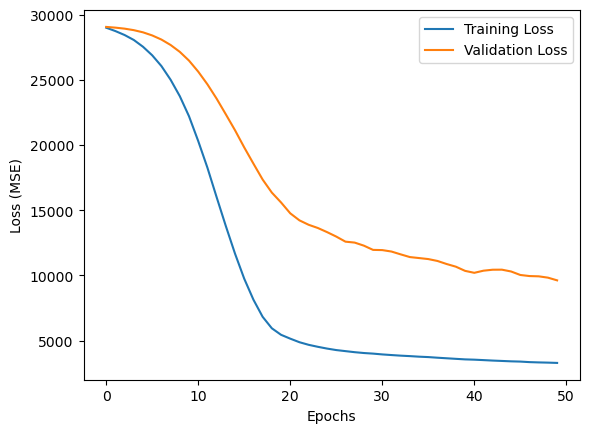

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# Generate synthetic regression data
#X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = np.array(df_train.iloc[:,0:10]),np.array(df_test.iloc[:,0:10]),np.array(df_train['target']),np.array(df_test['target'])

# Normalize data (important for neural networks)
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),                                   # Hidden layer
    Dense(1)                                                        # Output layer (no activation for regression)
]

# Compile the model
model.compile(
    optimizer='adam',              # Adaptive learning rate optimizer
    loss='mean_squared_error',     # MSE for regression
    metrics=['mean_absolute_error']  # Optional: Track MAE
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,                    # Number of training iterations
    batch_size=32,                # Batch size
    verbose=1                     # Show progress
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## alibi workflow

In [5]:
from alibi.explainers import CounterfactualProto

/opt/anaconda3/envs/alibi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/alibi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
variable_names = list(df_train.columns[0:10])
variable_names

['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

In [7]:
X_train = np.array(df_train.iloc[:,0:10])
shape = X_train.shape

In [8]:
X_train.shape

(353, 10)

In [9]:
X_train[1]

array([ 0.00175052, -0.04464164, -0.00836158, -0.06419941, -0.03871969,
       -0.02448686,  0.00446045, -0.03949338, -0.06468302, -0.05492509])

In [10]:
X1 = X_train[1].reshape((1,) + X_train[1].shape)
shape2= X1.shape
shape2

(1, 10)

In [11]:
X_train.min(axis=0)

array([-0.10722563, -0.04464164, -0.0902753 , -0.10895673, -0.12678067,
       -0.11561307, -0.09862541, -0.0763945 , -0.12609739, -0.12948301])

In [15]:
explainer_alibi = CounterfactualProto(model.predict, shape2) #, use_kdtree=True, theta=10., max_iterations=1000,
                         #feature_range=(X_train.min(axis=0), X_train.max(axis=0)),
                         #c_init=1., c_steps=10)

explainer_alibi.fit(X_train)

AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'get_session'

In [16]:
from alibi.explainers import CounterfactualProto

# Ensure TensorFlow 2.x is in eager mode (default)
tf.compat.v1.disable_eager_execution()  # Disable if needed (legacy support)

# Define the explainer (use `predict_fn` instead of `model.predict`)
def predict_fn(X):
    return model.predict(X)

explainer = CounterfactualProto(
    predict_fn,
    shape=X_train.shape[1:],  # Input shape (e.g., (10,) for 10 features)
    feature_range=(X_train.min(axis=0), X_train.max(axis=0)),
    use_kdtree=True,          # Optional: For faster search
    theta=10.,                # Regularization parameter
    max_iterations=1000
)

# Fit the explainer
explainer.fit(X_train)

AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'get_session'

In [18]:
import tensorflow
tensorflow.__version__

'2.16.1'

In [19]:
explainer_alibi = CounterfactualProto(rf_sk_np_model.predict, shape, use_kdtree=True, theta=10., max_iterations=1000,
                         feature_range=(X_train.min(axis=0), X_train.max(axis=0)),
                         c_init=1., c_steps=10)

explainer_alibi.fit(X_train)

ImportError: Attempted to use CounterfactualProto without the correct optional dependencies installed. This may be due to missing or incompatible versions of dependencies. To install the correct optional dependencies, run `pip install alibi[tensorflow]` from the command line. For more information, check the installationdocumentation at https://docs.seldon.io/projects/alibi/en/latest/overview/getting_started.html.

In [ ]:
# explain an instance, in this case a patient
#explanation = explainer.explain(x)